# Lassa virus glycoprotein PacBio sequencing 
This example shows how to use [alignparse](https://jbloomlab.github.io/alignparse/) to process circular consensus sequences that map to multiple different targets. Here, our two targets are a wildtype and a codon optimized sequence for the Lassa virus (LASV) glycoprotein from the Josiah strain. For such targets we do not expect large internal deletions, so we use alignment settings optimized for codon-level mutations as these will be the settings used when analyzing mutant LASV GP sequences in later experiments.

Here we analyze a snippet of the full data set of circular consensus sequences so that the example is small and fast.

In the other included example notebooks ([RecA deep mutational scanning libraries](https://jbloomlab.github.io/alignparse/recA_DMS.html) and [Single-cell virus sequencing](https://jbloomlab.github.io/alignparse/flu_virus_seq_example.html)), we align and parse the PacBio reads using the single [align_and_parse](https://jbloomlab.github.io/alignparse/alignparse.targets.html#alignparse.targets.Targets.align_and_parse) function. Here we use separate functions to do the aligning and parsing steps. This illustrates an additional use case and shows how this package could be used to parse alignments generated elsewhere as long as they have a [cs tag](https://lh3.github.io/minimap2/minimap2.html#10) and are in the SAM file format.

## Set up for analysis
Import necessary Python modules:

In [1]:
import os
import tempfile
import warnings

import Bio.SeqIO

import pandas as pd
import numpy

from plotnine import *

import pysam

import alignparse.ccs
import alignparse.minimap2
import alignparse.targets
import alignparse.cs_tag
import alignparse.consensus

Suppress warnings that clutter output:

In [2]:
warnings.simplefilter('ignore')

Directory for output:

In [3]:
outdir = './output_files/'
os.makedirs(outdir, exist_ok=True)

Color palette for plots:

In [4]:
CBPALETTE = ('#999999', '#E69F00', '#56B4E9', '#009E73')

## Target amplicons
We have performed sequencing of several LASV GP amplicons that include the glycoprotein sequence along with a PacBio index and several other features. Here we analyze reads mapping to two of these amplicons.
The amplicons are defined in [Genbank Flat File format](https://www.ncbi.nlm.nih.gov/genbank/samplerecord/).
If there are multiple targets, they can all be defined in a single Genbank file (as we did in the [Single-cell virus sequencing](https://jbloomlab.github.io/alignparse/flu_virus_seq_example.html) example) or each target can be defined in its own Genbank file (as we've done here).

First, let's just look at the files:

In [5]:
target_file_names = ['LASV_Josiah_WT', 'LASV_Josiah_OPT']

targetfiles = [f"input_files/{target_file_name}.gb" for target_file_name in target_file_names]

for targetfile in targetfiles:
    with open(targetfile) as f:
        print(f.read())

LOCUS       LASV_Josiah_WT          1730 bp ds-DNA     linear       14-JUN-2019
DEFINITION  .
ACCESSION   
VERSION     
SOURCE      Kate Crawford
  ORGANISM  .
COMMENT     
COMMENT     
COMMENT     PacBio amplicon for LASV Josiah WT sequence
COMMENT     
COMMENT     ApEinfo:methylated:1
FEATURES             Location/Qualifiers
     T2A             85..147
                     /label="T2A"
     WPRE            1639..1730
                     /label="WPRE"
     ZsGreen         15..84
                     /label="ZsGreen"
     termini3        1639..1730
                     /label="3'Termini"
     index           9..14
                     /label="index"
     leader5         1..8
                     /label="5' leader"
     termini5        1..147
                     /label="5'Termini"
     variant_tag5    34..34
                     /variant_1=T
                     /variant_2=C
                     /label="5'VariantTag"
     variant_tag3    1702..1702
                     /variant_1=G
 

Along with the Genbank files giving the sequences of the amplicons, we have a YAML file specifying how to filter and parse alignments to these amplicons.

Below is the text of the YAML file.

Additional information about these filters can be found in the [RecA deep mutational scanning libraries](https://jbloomlab.github.io/alignparse/recA_DMS.html) example notebook or the [Targets](https://jbloomlab.github.io/alignparse/alignparse.targets.html#alignparse.targets.Targets) documentation. 

A filter setting of `null` indicates this filter is not applied. When filters are missing for a feature, they are automatically set to zero.

Here we filter the `gene` based on `mutation_op_counts` by setting the `mutation_nt_counts` filter for the `gene` to `null`. Although we do not expect these sequences to have large indels, we want to confirm this. Filtering on mutation "operations" allows us to retain sequences with large indels by only filtering on the number of indels, not the number of nucleotides inserted or deleted. Overall, this example uses very loose filters to allow us to do further analyses of the types of mutations that are arising in these samples.

The YAML file also specifies what information is parsed from alignments that are not filtered out.
As you can see, for some features we parse the mutations or the full sequence of the feature, along with the accuracy of that feature in the sequencing query (computed from the Q-values). 

As seen below, we can use YAML syntax to apply one set of filters to multiple targets. Here, we apply the same filters to both targets, but this is not necessary.

In [6]:
lasv_parse_specs_file = 'input_files/lasv_feature_parse_specs.yaml'
with open(lasv_parse_specs_file) as f:
    print(f.read())

LASV_Josiah_WT: &LASV_target_parse_specs
  query_clip5: 10
  query_clip3: 10
  termini5:
    filter:
      clip5: 10
      mutation_nt_count: 5
      mutation_op_count: null
  termini3:
    filter:
      clip3: 10
      mutation_nt_count: 5
      mutation_op_count: null
  gene:
    filter:
      mutation_nt_count: null
      mutation_op_count: 30
    return: [mutations, accuracy]
  spacer:
    filter:
      mutation_nt_count: 1
      mutation_op_count: null
  index:
    return: sequence
  variant_tag5:
    return: sequence
  variant_tag3:
    return: sequence

LASV_Josiah_OPT: *LASV_target_parse_specs



Read the amplicons in `feature_parse_specs` into a [Targets](https://jbloomlab.github.io/alignparse/alignparse.targets.html#alignparse.targets.Targets) object, specifying the features that we require the target to contain. The [Targets](https://jbloomlab.github.io/alignparse/alignparse.targets.html#alignparse.targets.Targets) in this example have more features specified in their Genbank files than we want to parse, so we set `allow_extra_features` to `True`.

In [7]:
targets = alignparse.targets.Targets(seqsfile=targetfiles,
                  feature_parse_specs=lasv_parse_specs_file,
                  allow_extra_features=True)

When we look at the [targets.feature_parse_specs](https://jbloomlab.github.io/alignparse/alignparse.targets.html#alignparse.targets.Targets.feature_parse_specs), we now see that the previously unspecified specs have been filled in with the defaults.

In [8]:
print(targets.feature_parse_specs('yaml'))

LASV_Josiah_WT: &id001
  query_clip5: 10
  query_clip3: 10
  termini5:
    filter:
      clip5: 10
      mutation_nt_count: 5
      mutation_op_count: null
      clip3: 0
    return: []
  termini3:
    filter:
      clip3: 10
      mutation_nt_count: 5
      mutation_op_count: null
      clip5: 0
    return: []
  gene:
    filter:
      mutation_nt_count: null
      mutation_op_count: 30
      clip5: 0
      clip3: 0
    return:
    - mutations
    - accuracy
  spacer:
    filter:
      mutation_nt_count: 1
      mutation_op_count: null
      clip5: 0
      clip3: 0
    return: []
  index:
    return:
    - sequence
    filter:
      clip5: 0
      clip3: 0
      mutation_nt_count: 0
      mutation_op_count: 0
  variant_tag5:
    return:
    - sequence
    filter:
      clip5: 0
      clip3: 0
      mutation_nt_count: 0
      mutation_op_count: 0
  variant_tag3:
    return:
    - sequence
    filter:
      clip5: 0
      clip3: 0
      mutation_nt_count: 0
      mutation_op_count: 0
LA

We can also plot the [Targets](https://jbloomlab.github.io/alignparse/alignparse.targets.html#alignparse.targets.Targets). All features specified in the targets' Genbank files will be annotated, even if they are not in `feature_parse_specs`.

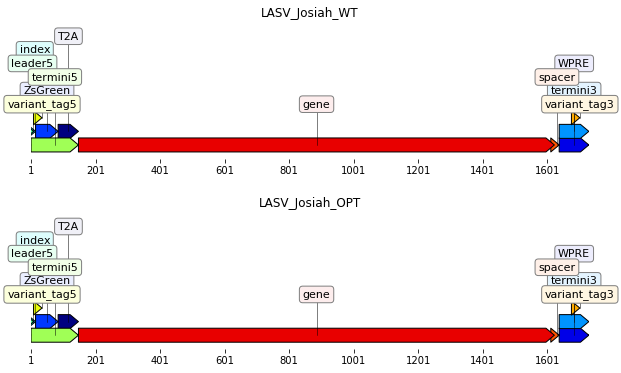

In [9]:
_ = targets.plot(ax_width=10)

## PacBio CCSs
We will align PacBio circular consensus sequences (CCSs) to the target.
First, we want to look at the CCSs.
A FASTQ file with these CCSs along with an associated report file were generated using the PacBio `ccs` program (see [here](https://github.com/PacificBiosciences/ccs) for details on `ccs`) using commands like the following (generates report file and BAM of CCSs):

    ccs --minLength 50 --maxLength 5000 \
        --minPasses 3  --minPredictedAccuracy 0.999 \
        --reportFile lasv_pilot_report.txt \
        --polish --numThreads 16 \
        lasv_pilot_subreads.bam lasv_pilot_ccs.bam
        
The BAM file was then converted to a FASTQ file using [samtools](http://www.htslib.org/) with flags to retain the number of passes (`np`) and read quality (`rq`). Here we convert the BAM file to a gzipped FASTQ file to demonstrate the use of compressed files:

    samtools bam2fq -T np,rq lasv_pilot_ccs.bam | gzip > lasv_pilot_ccs.fastq.gz
    
Here is a data frame with the resulting FASTQ and BAM files:

In [10]:
run_names = ['lasv_pilot']
ccs_dir = 'input_files'
file_name = 'lasv_example'

pacbio_runs = pd.DataFrame(
            {'name': run_names,
             'report': [f"{ccs_dir}/{name}_report.txt" for name in run_names],
             'fastq': [f"{ccs_dir}/{file_name}_ccs.fastq.gz"]
             })

pacbio_runs

,name,report,fastq
0,lasv_pilot,input_files/lasv_pilot_report.txt,input_files/lasv_example_ccs.fastq.gz


We create a [Summaries](https://jbloomlab.github.io/alignparse/alignparse.ccs.html#alignparse.ccs.Summaries) object for these CCSs:

In [11]:
ccs_summaries = alignparse.ccs.Summaries(pacbio_runs)

Plot how many ZMWs yielded CCSs:

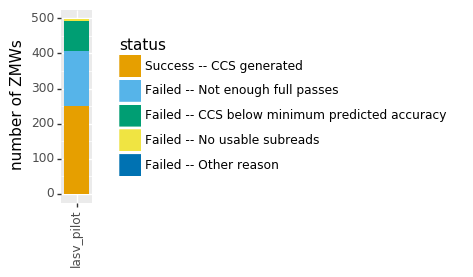

In [12]:
p = ccs_summaries.plot_zmw_stats()
_ = p.draw()

In [13]:
ccs_summaries.zmw_stats()

,name,status,number,fraction
0,lasv_pilot,Success -- CCS generated,250,0.4996
1,lasv_pilot,Failed -- Not enough full passes,157,0.3144
2,lasv_pilot,Failed -- CCS below minimum predicted accuracy,86,0.1720
3,lasv_pilot,Failed -- No usable subreads,6,0.0137
4,lasv_pilot,Failed -- Other reason,0,0.0000


Statistics on the CCSs (length, number of subread passes, accuracy):

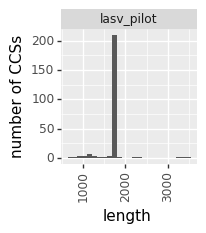

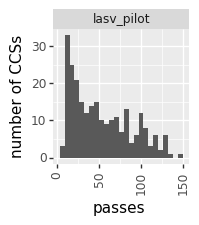

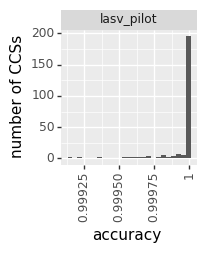

In [14]:
for stat in ['length', 'passes', 'accuracy']:
    if ccs_summaries.has_stat(stat):
        p = ccs_summaries.plot_ccs_stats(stat)
        _ = p.draw()
    else:
        print(f"No information available on CCS {stat}")

## Align CCSs to target
Now we use [minimap2](https://github.com/lh3/minimap2) to align the CCSs to the target.

First, we create a [Mapper](https://jbloomlab.github.io/alignparse/alignparse.minimap2.html#alignparse.minimap2.Mapper) object to run [minimap2](https://github.com/lh3/minimap2), using the options for codon-level deep mutational scanning (specified by [alignparse.minimap2.OPTIONS_CODON_DMS](https://jbloomlab.github.io/alignparse/alignparse.minimap2.html#alignparse.minimap2.OPTIONS_CODON_DMS)):

In [15]:
mapper = alignparse.minimap2.Mapper(alignparse.minimap2.OPTIONS_CODON_DMS)

print(f"Using `minimap2` {mapper.version} with these options:\n" +
      ' '.join(mapper.options))

Using `minimap2` 2.17-r941 with these options:
-A2 -B4 -O12 -E2 --end-bonus=13 --secondary=no --cs


Now use this mapper to do the alignments to a SAM file.
First, add the names of the desired alignment files to our data frame:

In [16]:
pacbio_runs = pacbio_runs.assign(alignments=lambda x: outdir + x['name'] + '_alignments.sam')

pacbio_runs

,name,report,fastq,alignments
0,lasv_pilot,input_files/lasv_pilot_report.txt,input_files/lasv_example_ccs.fastq.gz,./output_files/lasv_pilot_alignments.sam


Now we run [targets.align](https://jbloomlab.github.io/alignparse/alignparse.targets.html#alignparse.targets.Targets.align) using the mapper to actually align the FASTQ queries to the target:

In [17]:
for tup in pacbio_runs.itertuples(index=False):
    print(f"Aligning {tup.fastq} to create {tup.alignments}...")
    targets.align(queryfile=tup.fastq,
                  alignmentfile=tup.alignments,
                  mapper=mapper)

Aligning input_files/lasv_example_ccs.fastq.gz to create ./output_files/lasv_pilot_alignments.sam...


These SAM files now contain the alignments along with the [cs tag](https://github.com/lh3/minimap2#cs). 

An example [cs tag](https://github.com/lh3/minimap2#cs) is:

In [18]:
for fname in pacbio_runs['alignments'][:1]:
    with pysam.AlignmentFile(fname) as f:
        a = next(f)
        print(f"First alignment in {fname} has `cs` tag:\n" + a.get_tag('cs'))

First alignment in ./output_files/lasv_pilot_alignments.sam has `cs` tag:
:8*ng*na*ng*na*nc*ng:19*nc:1667*na:28


## Parse the alignments
Now we use [Targets.parse_alignments](https://jbloomlab.github.io/alignparse/alignparse.targets.html#alignparse.targets.Targets.parse_alignment) to parse the SAM files to get the information we specified for return.
This function returns a data frame (`readstats`) on the overall parsing stats, plus dicts keyed by the names of each target in [Targets](https://jbloomlab.github.io/alignparse/alignparse.targets.html#alignparse.targets.Targets) giving data frames of the aligned and filtered reads. Here we return the `aligned` and `filtered` reads as dictionaries of data frames. 

The `aligned` and `filtered` read information can instead be returned as CSV files containing these data frames by setting the `to_csv` argument to `True`. Note: When using the combined [Targets.align_and_parse](https://jbloomlab.github.io/alignparse/alignparse.targets.html#alignparse.targets.Targets.align_and_parse) function as in the other example notebooks ([RecA DMS libraries](https://jbloomlab.github.io/alignparse/recA_DMS.html) and [Single-cell virus sequencing](https://jbloomlab.github.io/alignparse/flu_virus_seq_example.html)), these CSV files will always be created, even if `to_csv` is `False` and the [align_and_parse](https://jbloomlab.github.io/alignparse/alignparse.targets.html#alignparse.targets.Targets.align_and_parse) function is returning `aligned` and `filtered` as dictionaries of data frames in its final output.

Here we only have one PacBio run, but in practice we will often have multiple. As such, our example shows how to concatenate the `readstats`, `aligned`, and `filtered` data frames for each PacBio run and then look at the data frames together:

In [19]:
readstats = []
aligned = {targetname: [] for targetname in targets.target_names}
filtered = {targetname: [] for targetname in targets.target_names}

for run in pacbio_runs.itertuples():
    
    print(f"Parsing PacBio run {run.name}")
    run_readstats, run_aligned, run_filtered = targets.parse_alignment(run.alignments, filtered_cs=True)
    
    # when concatenating add the run name to keep track of runs for results
    readstats.append(run_readstats
                     .assign(run_name=run.name)
                     )
    for targetname in targets.target_names:
        aligned[targetname].append(run_aligned[targetname]
                                   .assign(run_name=run.name)
                                   )
        filtered[targetname].append(run_filtered[targetname]
                                    .assign(run_name=run.name)
                                    )
        
# now concatenate the data frames for each run
readstats = pd.concat(readstats, ignore_index=True, sort=False)
for targetname in targets.target_names:
    aligned[targetname] = pd.concat(aligned[targetname], ignore_index=True, sort=False)
    filtered[targetname] = pd.concat(filtered[targetname], ignore_index=True, sort=False)

Parsing PacBio run lasv_pilot


First lets look at the read stats:

From the known composition of the library, there should be more `LASV_Josiah_OPT` reads than `LASV_Josiah_WT`.

In [20]:
readstats

,category,count,run_name
0,filtered LASV_Josiah_WT,23,lasv_pilot
1,aligned LASV_Josiah_WT,84,lasv_pilot
2,filtered LASV_Josiah_OPT,32,lasv_pilot
3,aligned LASV_Josiah_OPT,111,lasv_pilot
4,unmapped,0,lasv_pilot


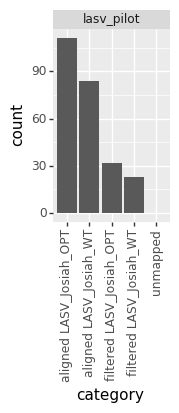

In [21]:
p = (
    ggplot(readstats, aes('category', 'count')) +
    geom_bar(stat='identity') +
    facet_wrap('~ run_name', nrow=1) +
    theme(axis_text_x=element_text(angle=90),
          figure_size=(1.5 * len(pacbio_runs), 2.5)
          )
    )
_ = p.draw()

Now look at the information on the filtered reads.
This is a bigger data frame, so we just look at the first few lines for the first target (of which there is only one anyway):

In [22]:
filtered[targets.target_names[0]].head()

,query_name,filter_reason,filter_cs,run_name
0,m54228_190605_190010/4194989/ccs,termini5 clip5,*nc*na*nc:19*nc:113,lasv_pilot
1,m54228_190605_190010/4260241/ccs,index clip5,*ng*na*nc*na*nc,lasv_pilot
2,m54228_190605_190010/4260334/ccs,query_clip5,None,lasv_pilot
3,m54228_190605_190010/4391712/ccs,termini5 clip5,,lasv_pilot
4,m54228_190605_190010/4456843/ccs,termini3 clip3,,lasv_pilot


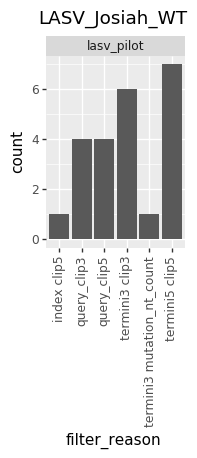

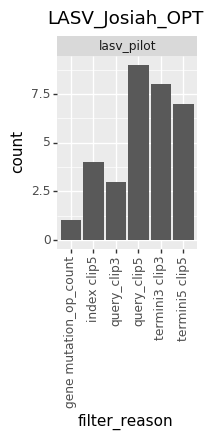

In [23]:
for targetname in targets.target_names:
    target_filtered = filtered[targetname]
    nreasons = target_filtered['filter_reason'].nunique()
    p = (
        ggplot(target_filtered, aes('filter_reason')) +
        geom_bar() +
        facet_wrap('~ run_name', nrow=1) +
        labs(title=targetname) +
        theme(axis_text_x=element_text(angle=90),
              figure_size=(0.3 * nreasons * len(pacbio_runs), 2.5),
              )
        )
    _ = p.draw()

## Error filtering

Before looking at the information for the validly aligned (not filtered) reads, it is important to get a sense of the error rate for these sequencing reads. 

These reads do not have random barcodes on the initial viral entry protein plasmids, but we can use the `gene_accuracy` information output from constructing the `ccs`s to examine accuracy. 

We will do this using a similar method to that implemented in the [RecA DMS libraries](https://jbloomlab.github.io/alignparse/recA_DMS.html) example notebook. However, here we will plot the graphs for each target. 

We anticipate excluding all CCSs for which the error rate for either the gene or barcode is $>10^{-4}$.
We specify this cutoff below.

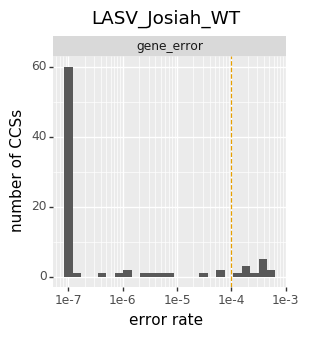

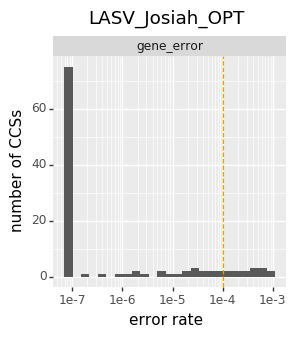

In [24]:
error_rate_floor = 1e-7  # error rates < this set to this
error_cutoff = 1e-4

for targetname in targets.target_names:
    aligned[targetname] = (
                  aligned[targetname]
                  .assign(
                          gene_error=lambda x: numpy.clip(1 - x['gene_accuracy'],
                                                          error_rate_floor, None)
                          )
                  )
    p = (
         ggplot(aligned[targetname]
                .melt(id_vars=['run_name'],
                      value_vars=['gene_error'],
                      var_name='feature_type', value_name='error rate'),
                aes('error rate')) +
         geom_histogram(bins=25) +
         geom_vline(xintercept=error_cutoff,
                    linetype='dashed',
                    color=CBPALETTE[1]) +
         facet_grid('~ feature_type') +
         theme(figure_size=(3, 3)) +
         labs(y=('number of CCSs'), title=(targetname)) +
         scale_x_log10()
         )

    _ = p.draw()

Next, we store all reads with an error rate $<10^{-4}$ in new data frames for retained sequences. 

We will use these retained sequences for further analyses.

In [25]:
retained = {targetname: [] for targetname in targets.target_names}
for targetname in targets.target_names:
    target_retained = aligned[targetname][aligned[targetname]['gene_error'] <= error_cutoff].reset_index(drop=True)
    retained[targetname] = target_retained

## Data analysis

Now we can examine our data in more detail. 

We will only display a few columns so the example renders well in the documentation. First, let's look at the `query_name`, `gene_mutations`, and `index_sequence` columns for the first few entries in the `retained` data frame for each target:

In [26]:
display_columns = ['query_name', 'gene_mutations', 'index_sequence']
for target_name in targets.target_names:
    print(target_name)
    display(retained[target_name][display_columns].head())

LASV_Josiah_WT


,query_name,gene_mutations,index_sequence
0,m54228_190605_190010/4194436/ccs,,GGTATG
1,m54228_190605_190010/4194472/ccs,T572C,GGTATG
2,m54228_190605_190010/4194509/ccs,,GGTATG
3,m54228_190605_190010/4194553/ccs,,GGTATG
4,m54228_190605_190010/4194576/ccs,,AGACAC


LASV_Josiah_OPT


,query_name,gene_mutations,index_sequence
0,m54228_190605_190010/4194382/ccs,,GAGACG
1,m54228_190605_190010/4194390/ccs,,ACGACC
2,m54228_190605_190010/4194399/ccs,,ACGACC
3,m54228_190605_190010/4194439/ccs,,ACGACC
4,m54228_190605_190010/4194445/ccs,,CTTCAC


As seen by the `index_sequence` columns, each target here has 2 or 3 different indices that map to it. These indicies indicate different samples. 

We can then split these data frames into sample-specific data frames based on the known starting index sequences for each target. We will store these data frames in a new dictionary, keyed by target and index.

In [27]:
indices = {'LASV_Josiah_WT': ['AGACAC', 'GGTATG'], 'LASV_Josiah_OPT': ['ACGACC', 'CTTCAC', 'GAGACG']}
target_idx_retained = {}
index_counts = {target: [] for target in indices}
index_counts_dfs = {}
for target_name in targets.target_names:
    for index in indices[target_name]:
        target_idx_retained[f"{target_name}_{index}"] = retained[target_name][retained[target_name]['index_sequence'] == index].reset_index(drop=True)
        index_counts[f"{target_name}"].append((index, len(target_idx_retained[f"{target_name}_{index}"])))
    index_counts[f"{target_name}"].append(('invalid', (len(retained[target_name]) - 
                                                          sum(idx_tup[1] for idx_tup in index_counts[target_name]))))
    index_counts_dfs[target_name] = pd.DataFrame(index_counts[target_name], columns=['index', 'count'])

In the process of making these separate data frames, we also kept track of how many reads for each target map to each index or don't map to an index (so have an 'invalid' index) and can now plot these counts. As seen below, only one sequence in this example has an invalid index and it maps to the `LASV_Josiah_OPT` target.

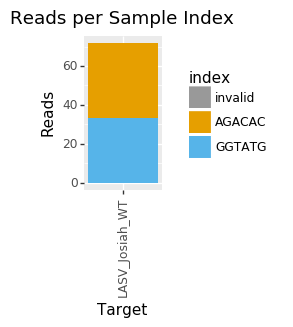

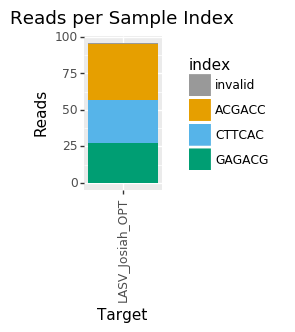

In [28]:
for target_name in targets.target_names:
    df = index_counts_dfs[target_name]
    df['target'] = [target_name]*len(df)
    id_order = ['invalid'] + df['index'][:-1].to_list()
    df['index'] = pd.Categorical(df['index'], categories=id_order, ordered=True)
    index_count_plot = (ggplot(df, aes(x='target', y='count', fill='index')) +
                        geom_bar(stat='identity', position='stack') +
                        scale_fill_manual(values=CBPALETTE) +
                        theme(axis_text_x=element_text(angle=90, vjust=1, hjust=0.5),
                        figure_size=(1, 2)) +
                        ylab('Reads') +
                        xlab('Target') +
                        ggtitle('Reads per Sample Index'))
    
    _ = index_count_plot.draw()

The two target-specific data frames are now five index-specific data frames. Again we will display the `query_name`, `gene_mutations`, and `index_sequence` columns.

In [29]:
for target_idx in target_idx_retained:
    print(target_idx)
    display(target_idx_retained[target_idx][display_columns].head(3))

LASV_Josiah_WT_AGACAC


,query_name,gene_mutations,index_sequence
0,m54228_190605_190010/4194576/ccs,,AGACAC
1,m54228_190605_190010/4194612/ccs,,AGACAC
2,m54228_190605_190010/4194613/ccs,,AGACAC


LASV_Josiah_WT_GGTATG


,query_name,gene_mutations,index_sequence
0,m54228_190605_190010/4194436/ccs,,GGTATG
1,m54228_190605_190010/4194472/ccs,T572C,GGTATG
2,m54228_190605_190010/4194509/ccs,,GGTATG


LASV_Josiah_OPT_ACGACC


,query_name,gene_mutations,index_sequence
0,m54228_190605_190010/4194390/ccs,,ACGACC
1,m54228_190605_190010/4194399/ccs,,ACGACC
2,m54228_190605_190010/4194439/ccs,,ACGACC


LASV_Josiah_OPT_CTTCAC


,query_name,gene_mutations,index_sequence
0,m54228_190605_190010/4194445/ccs,,CTTCAC
1,m54228_190605_190010/4194501/ccs,,CTTCAC
2,m54228_190605_190010/4194549/ccs,,CTTCAC


LASV_Josiah_OPT_GAGACG


,query_name,gene_mutations,index_sequence
0,m54228_190605_190010/4194382/ccs,,GAGACG
1,m54228_190605_190010/4194467/ccs,,GAGACG
2,m54228_190605_190010/4194491/ccs,,GAGACG


We can add mutation info for the genes in these targets using [alignparse.consensus.add_mut_info_cols](https://jbloomlab.github.io/alignparse/alignparse.consensus.html#alignparse.consensus.add_mut_info_cols).

In [30]:
for target_idx in target_idx_retained:
    target_idx_retained[target_idx] = alignparse.consensus.add_mut_info_cols(target_idx_retained[target_idx],
                                                                              mutation_col='gene_mutations',
                                                                              n_sub_col='n_gene_subs',
                                                                              n_indel_col='n_gene_indels')

We can then plot the number of reads for each sample that has each number of substitutions or indels to get a sense of how many mutations are in these reads, if some smaples have more mutations than others, and if substitutions or indels are more prevalent in these sequences. 

With such a small sample snippet of the data, it is difficult to make any conclusions, but with a full dataset, this can provide important information about the mutational processes at work for each sample.

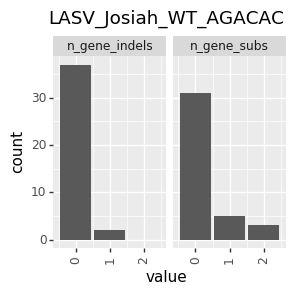

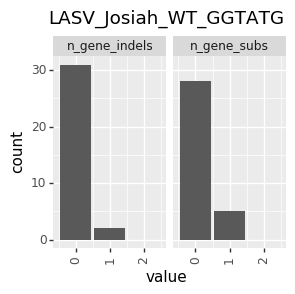

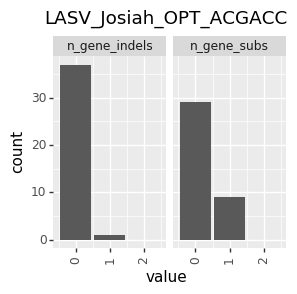

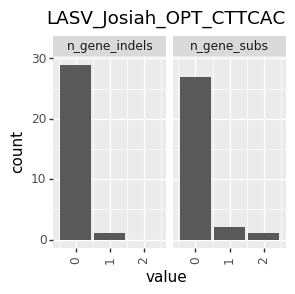

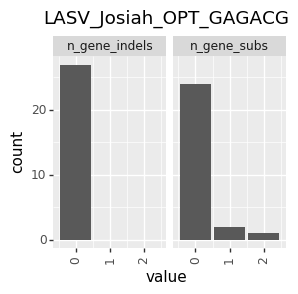

In [31]:
mut_cols = ['n_gene_subs', 'n_gene_indels']
for target_idx in target_idx_retained:
    target_idx_plot_muts = target_idx_retained[target_idx][mut_cols].melt()
    mut_counts_plot = (
                        ggplot(target_idx_plot_muts, aes('value')) +
                        geom_bar() +
                        facet_wrap('~ variable', ncol=2) +
                        xlim(-0.5, 2.5) +
                        labs(title=f"{target_idx}") +
                        theme(axis_text_x=element_text(angle=90),
                              figure_size=(3, 2.5),
                              )
    )
    _ = mut_counts_plot.draw()